In [1]:
import pandas as pd
import numpy as np
import os
import subprocess
import h5py

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

data_dir = '../Data'

In [2]:
# load data and preview

rawdata = pd.read_csv(data_dir + '/3000/data.csv')
rawdata[0:5]

,Unnamed: 0,gt_val,gt_sym,lt_val,lt_sym
0,2019-01-03,"[0.8706872487325694, 0.6136363069873223, 0.495...","['PHUN', 'NBSE', 'OCGN', 'BOXL', 'KTOV', 'BTAI...","([-0.3673469462229876, -0.26984126683776033, -...","['SESN', 'CCCL', 'SELB', 'ATRA', 'LTRPB', 'SFE..."
1,2019-01-04,"[1.0265407170232148, 0.6296295293346674, 0.327...","['PHUN', 'CGIX', 'EPZM', 'DRRX', 'TMDI', 'SUNW...","([-0.1925466206425025, -0.1573959338395985, -0...","['RBZ', 'TVIX', 'ELGX', 'ZBIO', 'BOXL', 'SQQQ'..."
2,2019-01-07,"[1.612167143201626, 0.4767024881329074, 0.4323...","['AXSM', 'ADXS', 'INSM', 'SAGE', 'PDSB', 'RBZ'...","([-0.5494845390218467, -0.5019011841153402, -0...","['CFRX', 'LJPC', 'NHTC', 'AXGN', 'CUTR', 'GSUM..."
3,2019-01-08,"[1.0444301396706108, 0.4708994668947917, 0.364...","['CLPS', 'MBOT', 'YI', 'PHUN', 'PLXP', 'ORGO',...","([-0.7539682502138672, -0.2285713847802603, -0...","['PROF', 'BRPAR', 'CFRX', 'ECOR', 'GWGH', 'AEY..."
4,2019-01-09,"[5.127232220625748, 1.5882352941176472, 1.4078...","['ORGO', 'PHUN', 'WINS', 'SAEX', 'VIVE', 'ATOS...","([-0.2503917207560298, -0.16546764132411507, -...","['SGH', 'MBOT', 'CLPS', 'AXSM', 'SGMO', 'MRIN'..."


In [3]:
# number of word in a long sentence
n_top = 500

# number of word in a sentence of embedding training set
n_similar = 20

# number of sentence in a sentence of embedding training set
n_sentence = 50000 

# function to get top 500 and bottom 500 for each day
def get_top(x, n=n_top):
    return(x.replace("[", "").replace("]", "").replace("'", "").replace(",", "").split(" ")[0:n])

# function to make the long sentence shorter, from 500 to 20
def get_similar(x, n=n_similar):
    ind = np.random.choice(len(x), n, replace=False)
    return( [x[i] for i in ind] )

In [4]:
# total number of unique long sentences

gt_top_list = [get_top(x, n_top) for x in rawdata.gt_sym]
lt_top_list = [get_top(x, n_top) for x in rawdata.lt_sym]
total_list = gt_top_list+lt_top_list
len(total_list)

502

In [5]:
# get 50000 long sentences from 502 unique long sentences
# then get 50000 short sentences with each containing 20 words

np.random.seed(1993)

ind = np.random.choice(len(total_list), n_sentence, replace=True)
output_list = [get_similar(total_list[i], n_similar) for i in ind]

print(len(output_list))
output_list[0]

50000


['MDGL',
 'RAND',
 'CCCL',
 'VOXX',
 'RIOT',
 'MBCN',
 'ATLO',
 'SRRK',
 'JRJC',
 'BVSN',
 'THMO',
 'LIND',
 'NEWA',
 'HX',
 'ANTE',
 'BIB',
 'JRSH',
 'SES',
 'ALDX',
 'MOGO']

In [6]:
# generate training set of embedding

output = [element for lis in output_list for element in lis]
unique_stocks = set(output)
print(len(output))
print(len(unique_stocks))

1000000
2928


In [8]:
out_dir = '../Data/3000/symbols.txt'
with open(out_dir, 'w', encoding='utf-8') as fout:
        for word in unique_stocks:
            fout.write(word+'\n')

In [10]:
%run get_vocab.py

In [7]:
out_dir = '../Data/stocks_emb_train.txt'
with open(out_dir, 'w', encoding='utf-8') as fout:
        for word in output:
            fout.write(word+' ')


In [11]:
# use fastText to train

cmd = "./fasttext skipgram -epoch 5 -minCount 0 -dim 100 -thread 12 -ws 5 -neg 5 -input Data/stocks_emb_train.txt -output Data/stocks_emb 1>data/stocks_emb.log 2>&1"

result = subprocess.run(cmd, capture_output=True, text=True, shell=True)
print(result.stdout)
print(result.stderr)

In [12]:
# get .w2vec for next step
%run generate_d2gpo_embedding.py ../Data/stocks_emb.bin ../Data/stocks_symbols.vocab ../Data/stocks_emb.vec ../Data/stocks_emb.w2vec


In [2]:
# get topological order with the pretrained embedding
%run generate_d2gpo_order.py ../Data/stocks_emb.w2vec ../Data/stocks_emb.order.txt ../Data/stocks_emb.order.idx


100%|██████████| 2928/2928 [00:07<00:00, 407.33it/s]


In [2]:
# get the prior distribution for each stocks
# if Gaussian evaluation function
%run generate_d2gpo_distribution.py gaussian 500 0 0 presoftmax 2 ../Data/stocks_emb.order.idx ../Data/stocks_emb.gaussian_1_0_0.h5


 39%|███▉      | 1153/2928 [00:00<00:00, 5770.76it/s]

[0.00034164 0.00034164 0.00034164 ... 0.0003415  0.0003415  0.0003415 ]


100%|██████████| 2928/2928 [00:00<00:00, 5676.77it/s]


In [ ]:
# if linear evaluation function

%run generate_d2gpo_distribution.py linear -0.0003 0 presoftmax 2 ../Data/stocks_emb.order.idx ../Data/stocks_emb.gaussian_1_0_0.h5

In [3]:
# prior distribution data

with h5py.File("../Data/stocks_emb.gaussian_1_0_0.h5", 'r') as f:
    dist_data = np.array(f.get('weights'))

dist_data.shape

(2928, 2928)

In [4]:
with open("../Data/stocks_emb.order.txt", 'r') as f:
    symbols_txt = f.readlines()
    
with open("../Data/stocks_emb.order.idx", 'r') as f:
    symbols_order = f.readlines()

symbols_txt = [x.split(" ") for x in symbols_txt]

In [5]:
temp_ind = [x[0] for x in symbols_txt]
AAPL_ind = [x=='AAPL' for x in temp_ind]
AAPL_ind = [i for i, val in enumerate(AAPL_ind) if val][0]

AAPL_ind

2488

In [6]:
AAPL_prior_dist = pd.concat([pd.Series(temp_ind), pd.Series(dist_data[AAPL_ind,:])], axis=1)
AAPL_prior_dist = AAPL_prior_dist.sort_values([1], ascending=False)
AAPL_prior_dist = AAPL_prior_dist.reset_index()

In [7]:
MSFT_ind = AAPL_prior_dist.index[AAPL_prior_dist[0] == 'MSFT'].tolist()[0]
FRBA_ind = AAPL_prior_dist.index[AAPL_prior_dist[0] == 'FRBA'].tolist()[0]
BANF_ind = AAPL_prior_dist.index[AAPL_prior_dist[0] == 'BANF'].tolist()[0]

[MSFT_ind, FRBA_ind, BANF_ind]

[47, 1744, 2186]

In [8]:
AAPL_prior_dist

,index,0,1
0,2488,AAPL,0.000342
1,1231,QTEC,0.000342
2,385,MINI,0.000342
3,2756,TXN,0.000342
4,1320,TQQQ,0.000342
...,...,...,...
2923,2230,PANL,0.000342
2924,2231,WHF,0.000342
2925,2232,ACBI,0.000342
2926,1097,ONCS,0.000342


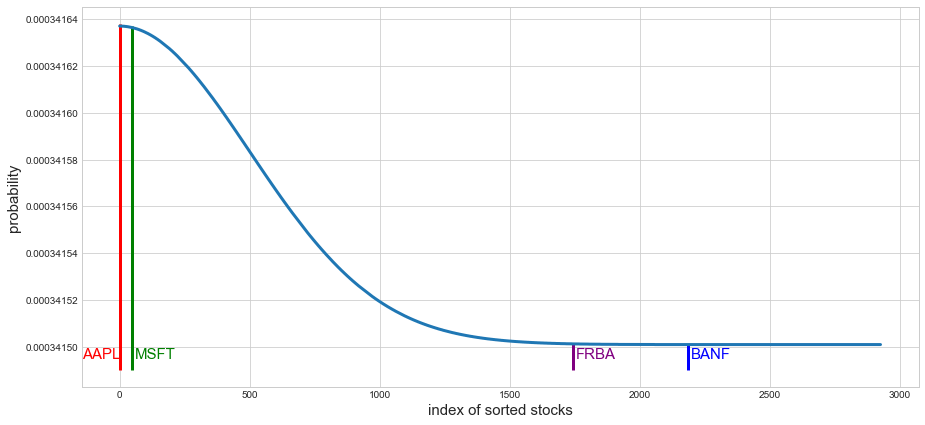

In [9]:
n = 2928

f = plt.figure(figsize = (15,7))
plt.plot(list(range(n)), AAPL_prior_dist[1][0:n], linewidth=3)
plt.xlabel('index of sorted stocks', size=15)  
plt.ylabel('probability', size=15)

plt.annotate('AAPL', (-145, 0.000341495), size=15, color='red')
plt.vlines(0, 0.00034149, 0.000341638, color='red', linewidth=3)

plt.annotate('MSFT', (MSFT_ind+10, 0.000341495), size=15, color='green')
plt.vlines(MSFT_ind, 0.00034149, 0.000341637, color='green', linewidth=3)

plt.annotate('FRBA', (FRBA_ind+10, 0.000341495), size=15, color='purple')
plt.vlines(FRBA_ind, 0.00034149, 0.000341501, color='purple', linewidth=3)

plt.annotate('BANF', (BANF_ind+10, 0.000341495), size=15, color='blue')
plt.vlines(BANF_ind, 0.00034149, 0.000341501, color='blue', linewidth=3)


In [10]:
f.savefig('line_plot.pdf')